In [7]:
!git clone https://github.com/misbah4064/face_mask_detection.git
%cd face_mask_detection

Cloning into 'face_mask_detection'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 15 (delta 1), reused 0 (delta 0), pack-reused 12
Unpacking objects: 100% (15/15), done.
/content/face_mask_detection


In [8]:
import cv2
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
from google.colab.patches import cv2_imshow

In [9]:
def thingspeak_post(valm):
 val= "x"+valm
 URl='https://api.thingspeak.com/update?api_key='
 KEY='HCO2S2AFNY7SWZZB'
 HEADER='&field1={}'.format(val)
 NEW_URL = URl+KEY+HEADER
 print(NEW_URL)
 data=urllib.request.urlopen(NEW_URL)
 print(data)

In [10]:
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_alt2.xml")
model = load_model("mask_recog.h5")

In [11]:
def face_mask_detector(frame):
 # frame = cv2.imread(fileName)
 gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
 faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(60, 60),
 flags=cv2.CASCADE_SCALE_IMAGE)
 faces_list=[]
 preds=[]
 for (x, y, w, h) in faces:
    face_frame = frame[y:y+h,x:x+w]
    face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
    face_frame = cv2.resize(face_frame, (224, 224))
    face_frame = img_to_array(face_frame)
    face_frame = np.expand_dims(face_frame, axis=0)
    face_frame = preprocess_input(face_frame)
    faces_list.append(face_frame)
    if len(faces_list)>0:
      preds = model.predict(faces_list)
    for pred in preds:
      (mask, withoutMask) = pred
    label = "Mask" if mask > withoutMask else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
    cv2.putText(frame, label, (x, y- 10),cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    cv2.rectangle(frame, (x, y), (x + w, y + h),color, 3)
 # cv2_imshow(frame)
 return frame,label


In [12]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode


In [13]:
def take_photo(filename='photo.jpg', quality=0.8):
 js = Javascript('''
 async function takePhoto(quality) {
 const div = document.createElement('div');
 const capture = document.createElement('button');
 capture.textContent = 'Capture';
 div.appendChild(capture);

 const video = document.createElement('video');
 video.style.display = 'block';
 const stream = await navigator.mediaDevices.getUserMedia({video: true});

 document.body.appendChild(div);
 div.appendChild(video);
 video.srcObject = stream;
 await video.play();

 // Resize the output to fit the video element.
 google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

 // Wait for Capture to be clicked.
 await new Promise((resolve) => capture.onclick = resolve);

 const canvas = document.createElement('canvas');
 canvas.width = video.videoWidth;
 canvas.height = video.videoHeight;
 canvas.getContext('2d').drawImage(video, 0, 0);
 stream.getVideoTracks()[0].stop();
 div.remove();
 return canvas.toDataURL('image/jpeg', quality);
 }
 ''')
 display(js)
 data = eval_js('takePhoto({})'.format(quality))
 binary = b64decode(data.split(',')[1])
 with open(filename, 'wb') as f:
  f.write(binary)
 return filename

In [14]:
import urllib.request
#posting data to thingspeak from python
val = 10 #your data to post it on thingspeak
url = "https://api.thingspeak.com/update?api_key=HCO2S2AFNY7SWZZB&field1=0"+str(val) #copy this from write a channel feed
response = urllib.request.urlopen(url)
print("Response after posting ",response,"\n")
#reading data from thingspeak and posting to python
url = "https://api.thingspeak.com/channels/1568925/feeds.json?api_key=98S63CPA7XSH64XR&results=2" #copy this from read a channel feed
response = urllib.request.urlopen(url)
print("Response after reading ",response.read(),"\n")

Response after posting  <http.client.HTTPResponse object at 0x7ff108292250> 

Response after reading  b'{"channel":{"id":1568925,"name":"face_mask","latitude":"0.0","longitude":"0.0","field1":"Field Label 1","created_at":"2021-11-12T10:16:34Z","updated_at":"2021-11-12T10:16:34Z","last_entry_id":72},"feeds":[{"created_at":"2021-12-10T03:25:06Z","entry_id":71,"field1":"010"},{"created_at":"2021-12-10T03:25:41Z","entry_id":72,"field1":"010"}]}' 



<IPython.core.display.Javascript object>

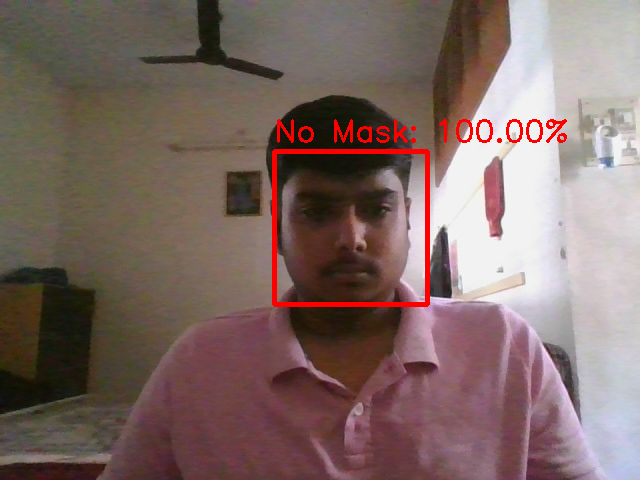

N
https://api.thingspeak.com/update?api_key=HCO2S2AFNY7SWZZB&field1=xN


In [15]:
input_image = cv2.imread(take_photo())
output,label = face_mask_detector(input_image)
cv2_imshow(output)
a=label[0]
print(a)
thingspeak_post(a)
